In [1]:
import os
import sys
import random
from PIL import Image
import numpy as np
import pandas as pd
#for image transform
import cv2

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import random
import time

sys.path.append('/root/dl2020')
#from model_loader_CP2 import *
from CP_helper_RCNN import *
from data_helper_RCNN import *
from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box
#from Unet import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.utils.data


 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
#from engine import train_one_epoch, evaluate


random.seed(0)
np.random.seed(0)
torch.manual_seed(0);
image_folder = '../data'
annotation_csv = '../data/annotation.csv'

unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)
train_labeled_scene_index, val_labeled_scene_index  = gen_train_val_index(labeled_scene_index)


normalize = torchvision.transforms.Normalize(mean=[0.6394939, 0.6755114, 0.7049375],
                                     std=[0.31936955, 0.3117349 , 0.2953726 ])

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                           normalize
                                           ])


kwargs = {
    #'first_dim': 'sample',
    'transform': transform,
    'image_folder': image_folder,
    'annotation_file': annotation_csv,
    'extra_info': True}

#dataset_train = LabeledDataset_RCNN (scene_index=train_labeled_scene_index, **kwargs)
#dataset_val = LabeledDataset_RCNN (scene_index=val_labeled_scene_index, **kwargs)

dataset_train = LabeledDataset(scene_index=train_labeled_scene_index, **kwargs)
dataset_val = LabeledDataset(scene_index=val_labeled_scene_index, **kwargs)





train_data_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=30, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

val_data_loader = torch.utils.data.DataLoader(
    dataset_val, batch_size=30, shuffle=False, num_workers=4,
    collate_fn=collate_fn)


#BEN CHANGED
# plot_image(sample[0].reshape(1,3,256,-1))
def sew_images(samples):
    new_samples = []
    for sample in samples:
        new_sample =  torch.cat([sample[0],sample[1],sample[2],sample[5],sample[4],sample[3]],axis = 2)
        new_samples.append(new_sample)
    return new_samples

def plot_image(img):
    plt.imshow(img.numpy().transpose(1, 2, 0))
    plt.axis('off');
    plt.show()
    #fig, ax = plt.subplots()

for i, (sample, old_targets, road_image, extra) in enumerate(val_data_loader): #, print_freq, header): 
        
        images = sew_images(sample)
        #print("images len {}, targets len {}".format(len(images), len(targets)))
        #print("images[0] shape {}".format(images[0].shape)) # [6, 3, 256, 306]      
        #images = list(image.to(device) for image in images)
        #targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        break
        


In [2]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 3x3 kernels
        #self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 8), 3x3 kernels
        #self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        #self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        #self.conv4 = nn.Conv2d(4, 16, 3, padding=1)
        #self.conv5 = nn.Conv2d(16, 1, 3, padding=1)
        
#         #V1 Kind of works
#         self.enc_conv1 = nn.Conv2d(3, 64, 3, padding=(1,1),stride=(1,5))
#         self.enc_conv2 = nn.Conv2d(64, 128, 3, padding=(1,8),stride=(2,3))
#         self.z = nn.ConvTranspose2d(128,3,3,stride=7,padding=46)
#         self.dec_conv1 = nn.Conv2d(3,128,3,stride=7,padding=46)
#         self.dec_conv2 = nn.ConvTranspose2d(128,64,3,stride=(2,3),padding=(1,8),output_padding=(1,0))
#         self.dec_conv3 = nn.ConvTranspose2d(64,3,3,stride=(1,5),padding=(1,1))

        self.enc_conv1 = nn.Conv2d(3, 16, 3, padding=(1,17),stride=(1,2))
        self.enc_conv2 = nn.Conv2d(16, 32, 3, padding=(1,17),stride=(1,2))
        self.enc_conv3 = nn.Conv2d(32, 64, 3, padding=(1,15),stride=(1,2))
        #pool = nn.MaxPool2d(2,2)
        self.z = nn.ConvTranspose2d(64,3,3,stride=3)
        
        self.dec_conv1 = nn.Conv2d(3,64,3,stride=3,padding=0)
        #dec_inv_pool = upsample
        self.dec_conv2 = nn.ConvTranspose2d(64, 32, 3, padding=(1,15),stride=(1,2))
        self.dec_conv3 = nn.ConvTranspose2d(32, 16, 3, padding=(1,17),stride=(1,2),output_padding=(0,1))
        self.dec_conv4 = nn.ConvTranspose2d(16, 3, 3, padding=(1,17),stride=(1,2),output_padding=(0,1))
        
        #for encoding
#         self.enc_conv1 = nn.Conv2d(3, 16, 3, padding=(1,17),stride=(1,2))
#         self.enc_conv2 = nn.Conv2d(16, 32, 3, padding=(1,17),stride=(1,2))
#         self.enc_conv3 = nn.Conv2d(32, 64, 3, padding=(1,15),stride=(1,2))
#         self.pool = nn.MaxPool2d(2,2)
#         self.z = nn.ConvTranspose2d(64,3,3,stride=7,padding=46)
        #for decoding
#         self.dec_conv1 = nn.Conv2d(3,64,3,stride=7,padding=46)
#         self.dec_inv_pool = self.upsample
#         self.dec_conv2 = nn.ConvTranspose2d(64, 32, 3, padding=(1,15),stride=(1,2))
#         self.dec_conv3 = nn.ConvTranspose2d(32, 16, 3, padding=(1,17),stride=(1,2),output_padding=(0,1))
#         self.dec_conv4 = nn.ConvTranspose2d(16, 3, 3, padding=(1,17),stride=(1,2),output_padding=(0,1))
    def return_image_tensor(self,x):
        with torch.no_grad():
            a = self.encode(x)
            return F.pad(a,pad=(16,16,16,16))
    def encode(self,x):
        #V1 encoder
        x = torch.tanh(self.enc_conv1(x))
        x = torch.tanh(self.enc_conv2(x))
        x = torch.tanh(self.enc_conv3(x))
        x = torch.sigmoid(self.z(x))
#         x = F.relu(self.enc_conv1(x))
#         x = F.relu(self.enc_conv2(x))
#         x = F.relu(self.enc_conv3(x))
#         x = self.pool(x)
#         x = F.relu(self.z(x))
        return x
    
    def decode(self,x):
        ## V1 decoder 
        x = torch.tanh(self.dec_conv1(x))
        x = torch.tanh(self.dec_conv2(x))
        x = torch.tanh(self.dec_conv3(x))
        x = torch.tanh(self.dec_conv4(x))
        
#         x = F.relu(self.dec_conv1(x))
#         x = self.dec_inv_pool(x)
#         x = F.relu(self.dec_conv2(x))
#         x = F.relu(self.dec_conv3(x))
#         x = F.relu(self.dec_conv4(x))
        return x
    
    def forward(self, x):
        # upsample, followed by a conv layer, with relu activation function  
        # this function is called `interpolate` in some PyTorch versions
        #x = F.upsample(x, scale_factor=2, mode='nearest')
        #x = F.relu(self.conv4(x))
        # upsample again, output should have a sigmoid applied
        #x = F.upsample(x, scale_factor=2, mode='nearest')
        #x = F.sigmoid(self.conv5(x))
        ##x = self.pool(x)  # compressed representation
        
        x = self.encode(x)
        x = self.decode(x)
        
        
        return x

# initialize the NN

In [3]:
inp = images[0].detach().cpu().unsqueeze(0)
enc_conv1 = nn.Conv2d(3, 16, 3, padding=(1,17),stride=(1,2))
enc_conv2 = nn.Conv2d(16, 32, 3, padding=(1,17),stride=(1,2))
enc_conv3 = nn.Conv2d(32, 64, 3, padding=(1,15),stride=(1,2))
z = nn.ConvTranspose2d(64,3,3,stride=3)
dec_conv1 = nn.Conv2d(3,64,3,stride=3,padding=0)
#dec_inv_pool = upsample
dec_conv2 = nn.ConvTranspose2d(64, 32, 3, padding=(1,15),stride=(1,2))
dec_conv3 = nn.ConvTranspose2d(32, 16, 3, padding=(1,17),stride=(1,2),output_padding=(0,1))
dec_conv4 = nn.ConvTranspose2d(16, 3, 3, padding=(1,17),stride=(1,2),output_padding=(0,1))
mod = nn.Sequential(*[enc_conv1,enc_conv2,enc_conv3,z,dec_conv1,dec_conv2,dec_conv3,dec_conv4])
#print(inp.shape)
for layer in mod:
   inp = layer(inp)
   print(inp.shape)

torch.Size([1, 16, 256, 934])
torch.Size([1, 32, 256, 483])
torch.Size([1, 64, 256, 256])
torch.Size([1, 3, 768, 768])
torch.Size([1, 64, 256, 256])
torch.Size([1, 32, 256, 483])
torch.Size([1, 16, 256, 934])
torch.Size([1, 3, 256, 1836])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch [1/500], loss:0.2790


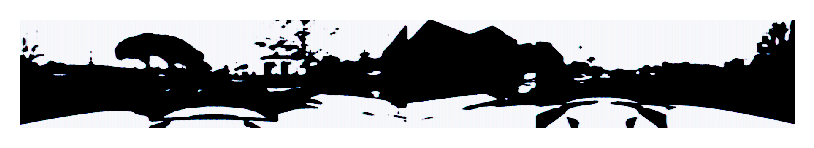

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


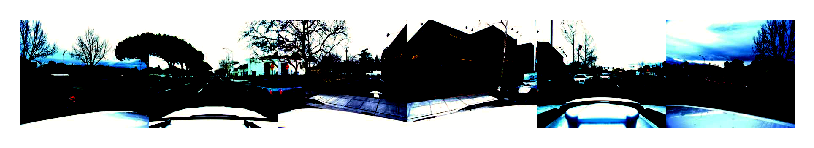

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch [2/500], loss:0.2109


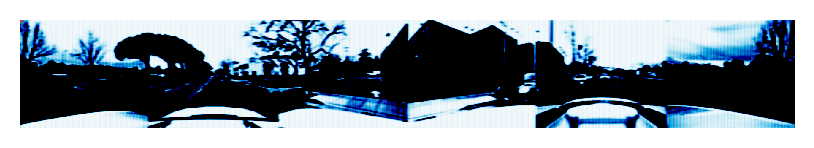

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


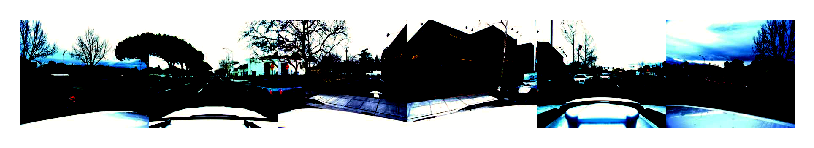

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch [3/500], loss:0.1826


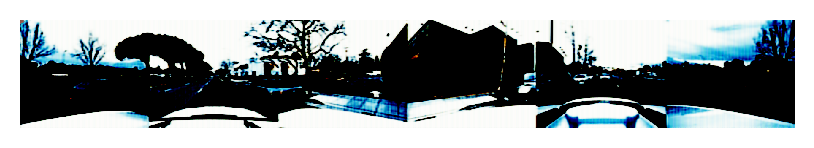

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


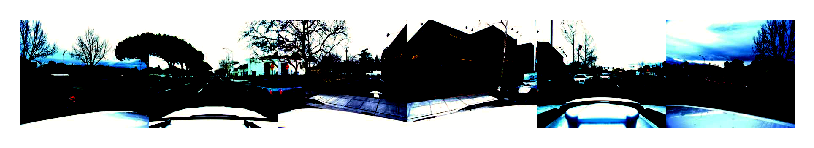

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch [4/500], loss:0.1744


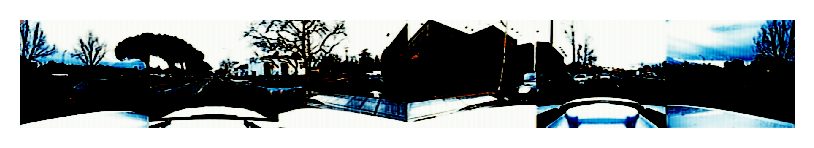

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


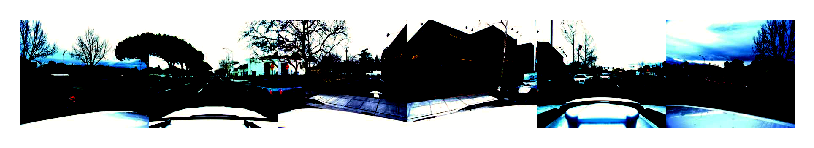

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch [5/500], loss:0.1662


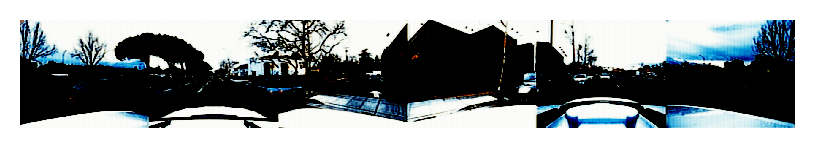

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


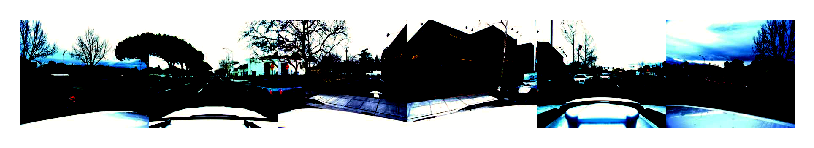

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch [6/500], loss:0.1623


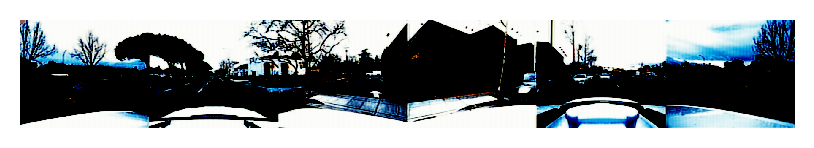

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


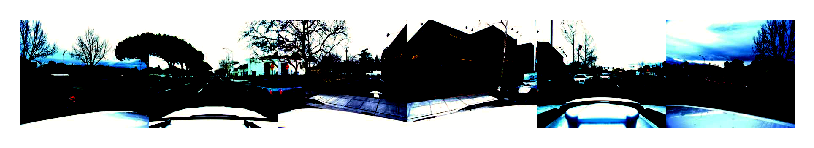

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch [7/500], loss:0.1605


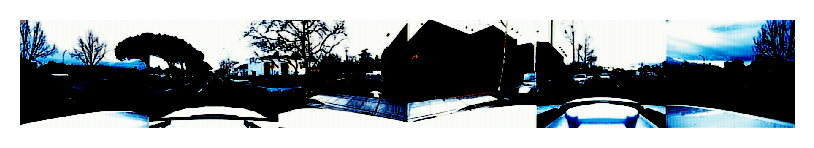

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


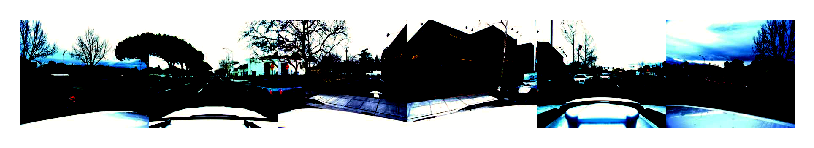

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch [8/500], loss:0.1585


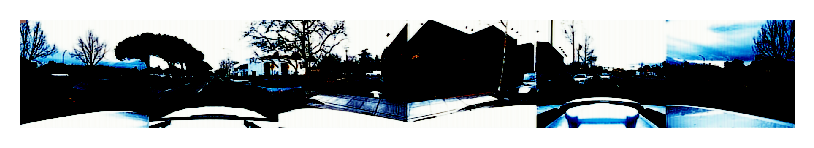

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


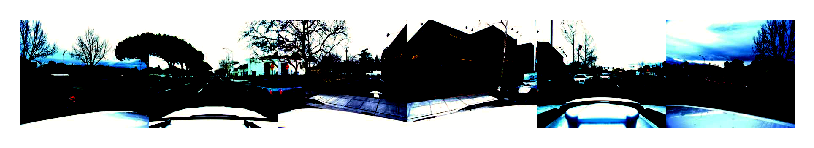

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch [9/500], loss:0.1570


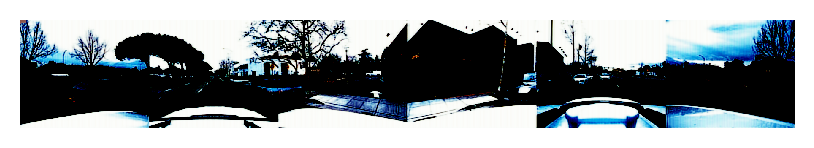

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


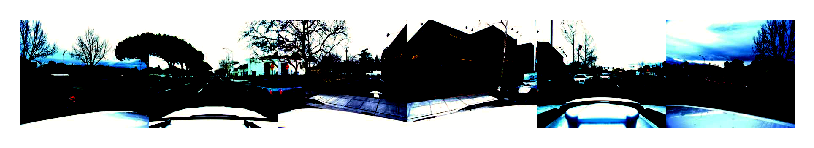

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch [10/500], loss:0.1558


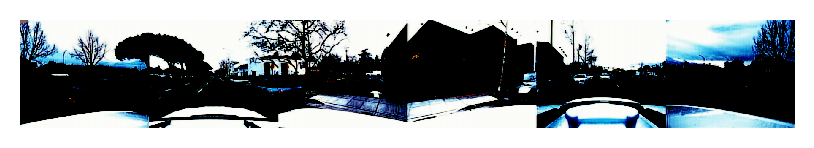

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


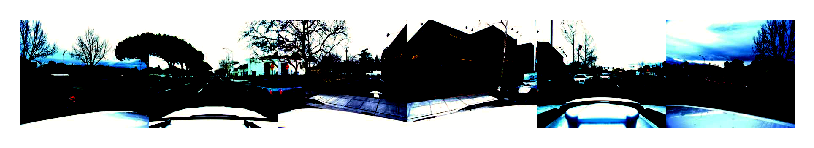

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch [11/500], loss:0.1552


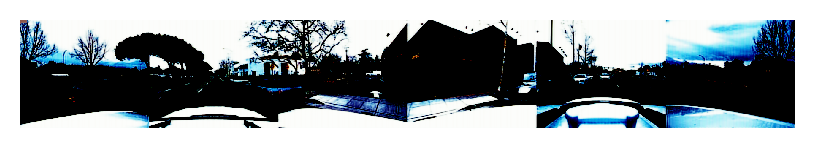

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


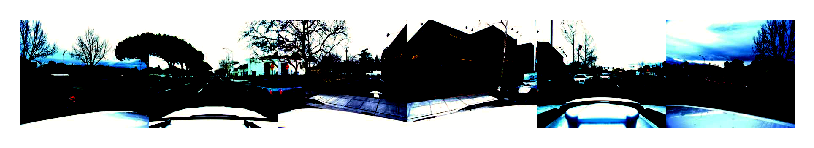

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch [12/500], loss:0.1544


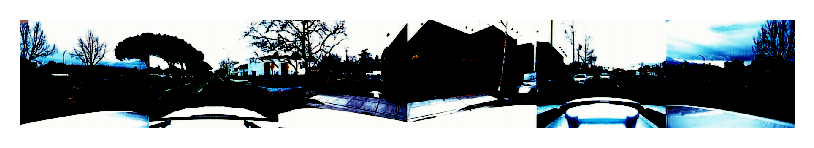

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


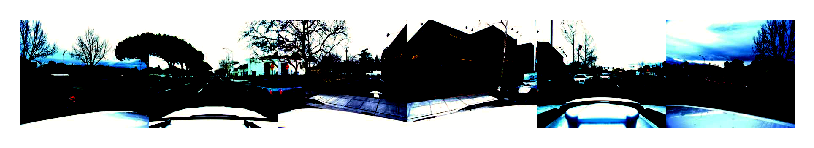

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch [13/500], loss:0.1538


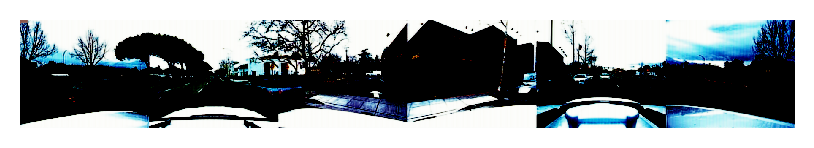

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


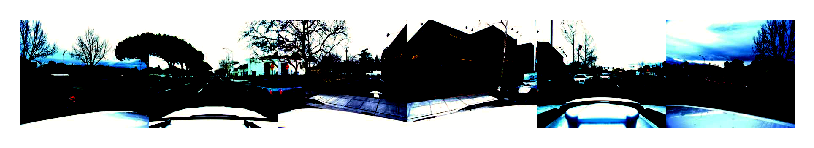

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch [14/500], loss:0.1535


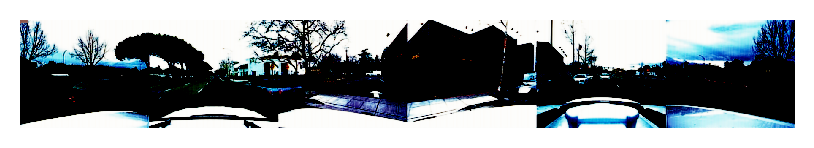

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


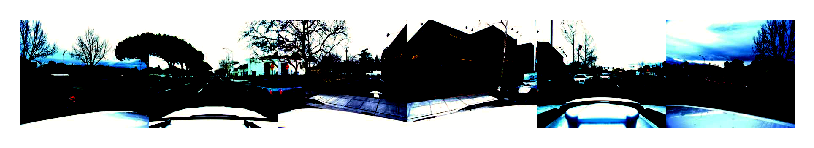

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch [15/500], loss:0.1534


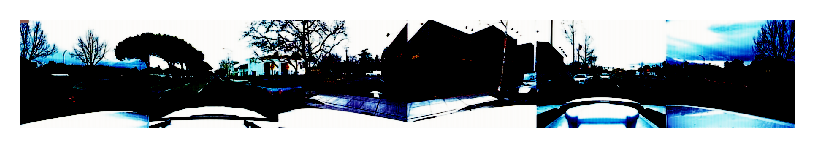

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


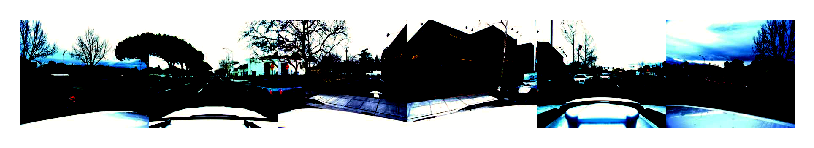

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch [16/500], loss:0.1532


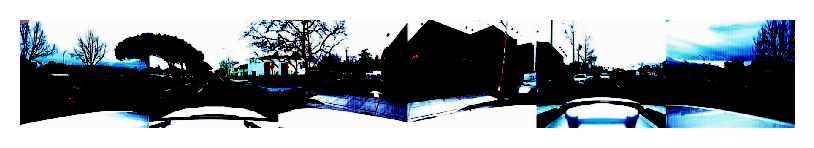

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


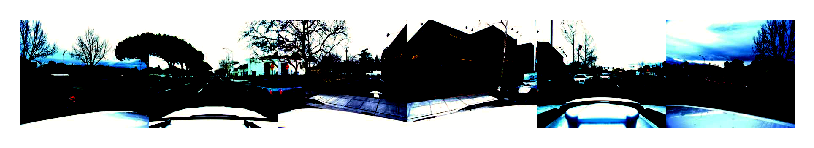

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch [17/500], loss:0.1524


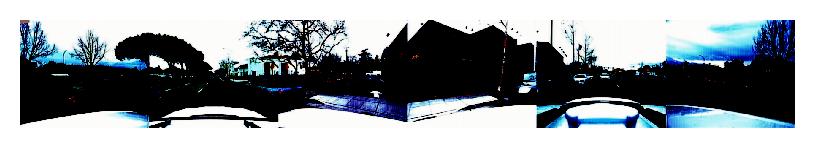

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


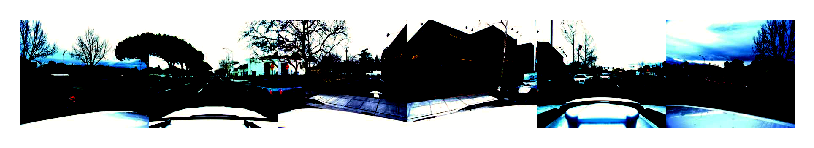

epoch [18/500], loss:0.1526


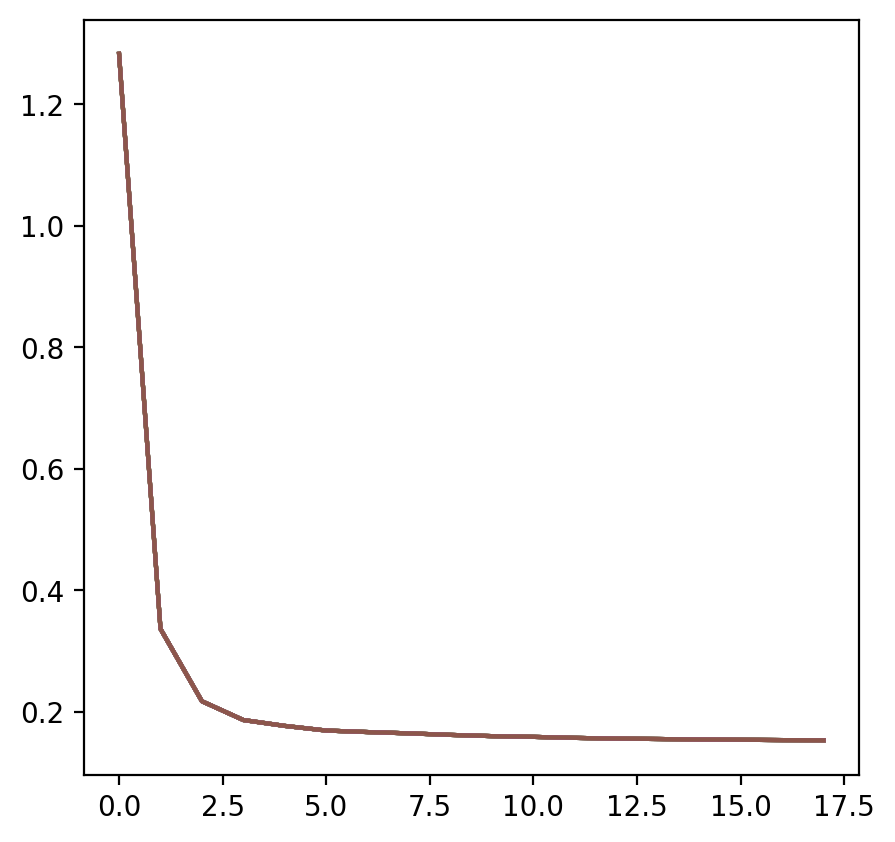

In [4]:
def calculate_val_loss(model):
    with torch.no_grad():
        val_model = model
        for i, (sample, old_targets, road_image, extra) in enumerate(val_data_loader):
            images = sew_images(sample)
            images = torch.stack([image.cuda() for image in images])
            # ===================forward=====================
            output = val_model(images)
            loss = criterion(output, images)
            break
    print('loss:{:.4f}'.format(loss.data))


model = ConvAutoencoder()
num_epochs = 500
batch_size = 128
learning_rate = 1.5e-3

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=1e-5,amsgrad=True)


model.cuda()
model.train()
losses = []
epoch_losses = []

for epoch in range(num_epochs):
    for i, (sample, old_targets, road_image, extra) in enumerate(train_data_loader):
        images = sew_images(sample)
        images = torch.stack([image.cuda() for image in images])
        # ===================forward=====================
        output = model(images)
        loss = criterion(output, images)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
        if i % 100 == 0:
            losses.append(loss.data.detach().cpu().numpy())
        if i%5 == 1:
            plt.plot(losses)
    
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, loss.data))
    epoch_losses.append(np.mean(losses[-3:]))
    if (len(epoch_losses) > 2) and (epoch_losses[-2] - epoch_losses[-1] < 0.0005):
        break
    plot_image(output[0].detach().cpu())
    plot_image(images[0].detach().cpu())
    if epoch % 100 == 99:
        torch.save(model.state_dict(),f"autoencoder_{new}.pt")

In [5]:
torch.save(model.state_dict(),f"autoencoder_new.pt")

In [9]:
model.encode(images).min()

tensor(0.0171, device='cuda:0', grad_fn=<MinBackward1>)

In [17]:
###file
%writefile auto_enc
import os
import sys
import random
from PIL import Image
import numpy as np
import pandas as pd
#for image transform
import cv2

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import random
import time

sys.path.append('/root/dl2020')
from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box
#from Unet import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.utils.data


random.seed(0)
np.random.seed(0)
torch.manual_seed(0);
image_folder = '../data'
annotation_csv = '../data/annotation.csv'

unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)
train_labeled_scene_index, val_labeled_scene_index  = gen_train_val_index(labeled_scene_index)


normalize = torchvision.transforms.Normalize(mean=[0.6394939, 0.6755114, 0.7049375],
                                     std=[0.31936955, 0.3117349 , 0.2953726 ])

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                           normalize
                                           ])


kwargs = {
    #'first_dim': 'sample',
    'transform': transform,
    'image_folder': image_folder,
    'annotation_file': annotation_csv,
    'extra_info': True}

#dataset_train = LabeledDataset_RCNN (scene_index=train_labeled_scene_index, **kwargs)
#dataset_val = LabeledDataset_RCNN (scene_index=val_labeled_scene_index, **kwargs)

dataset_train = LabeledDataset(scene_index=train_labeled_scene_index, **kwargs)
dataset_val = LabeledDataset(scene_index=val_labeled_scene_index, **kwargs)





train_data_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=30, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

val_data_loader = torch.utils.data.DataLoader(
    dataset_val, batch_size=30, shuffle=False, num_workers=4,
    collate_fn=collate_fn)


#BEN CHANGED
# plot_image(sample[0].reshape(1,3,256,-1))
def sew_images(samples):
    new_samples = []
    for sample in samples:
        new_sample =  torch.cat([sample[0],sample[1],sample[2],sample[5],sample[4],sample[3]],axis = 2)
        new_samples.append(new_sample)
    return new_samples

def plot_image(img):
    plt.imshow(img.numpy().transpose(1, 2, 0))
    plt.axis('off');
    plt.show()
    #fig, ax = plt.subplots()

# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 3x3 kernels
        #self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 8), 3x3 kernels
        #self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        #self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        #self.conv4 = nn.Conv2d(4, 16, 3, padding=1)
        #self.conv5 = nn.Conv2d(16, 1, 3, padding=1)
        
#         #V1 Kind of works
#         self.enc_conv1 = nn.Conv2d(3, 64, 3, padding=(1,1),stride=(1,5))
#         self.enc_conv2 = nn.Conv2d(64, 128, 3, padding=(1,8),stride=(2,3))
#         self.z = nn.ConvTranspose2d(128,3,3,stride=7,padding=46)
#         self.dec_conv1 = nn.Conv2d(3,128,3,stride=7,padding=46)
#         self.dec_conv2 = nn.ConvTranspose2d(128,64,3,stride=(2,3),padding=(1,8),output_padding=(1,0))
#         self.dec_conv3 = nn.ConvTranspose2d(64,3,3,stride=(1,5),padding=(1,1))

        self.enc_conv1 = nn.Conv2d(3, 16, 3, padding=(1,17),stride=(1,2))
        self.enc_conv2 = nn.Conv2d(16, 32, 3, padding=(1,17),stride=(1,2))
        self.enc_conv3 = nn.Conv2d(32, 64, 3, padding=(1,15),stride=(1,2))
        #pool = nn.MaxPool2d(2,2)
        self.z = nn.ConvTranspose2d(64,3,3,stride=3)
        
        self.dec_conv1 = nn.Conv2d(3,64,3,stride=3,padding=0)
        #dec_inv_pool = upsample
        self.dec_conv2 = nn.ConvTranspose2d(64, 32, 3, padding=(1,15),stride=(1,2))
        self.dec_conv3 = nn.ConvTranspose2d(32, 16, 3, padding=(1,17),stride=(1,2),output_padding=(0,1))
        self.dec_conv4 = nn.ConvTranspose2d(16, 3, 3, padding=(1,17),stride=(1,2),output_padding=(0,1))
        
        #for encoding
#         self.enc_conv1 = nn.Conv2d(3, 16, 3, padding=(1,17),stride=(1,2))
#         self.enc_conv2 = nn.Conv2d(16, 32, 3, padding=(1,17),stride=(1,2))
#         self.enc_conv3 = nn.Conv2d(32, 64, 3, padding=(1,15),stride=(1,2))
#         self.pool = nn.MaxPool2d(2,2)
#         self.z = nn.ConvTranspose2d(64,3,3,stride=7,padding=46)
        #for decoding
#         self.dec_conv1 = nn.Conv2d(3,64,3,stride=7,padding=46)
#         self.dec_inv_pool = self.upsample
#         self.dec_conv2 = nn.ConvTranspose2d(64, 32, 3, padding=(1,15),stride=(1,2))
#         self.dec_conv3 = nn.ConvTranspose2d(32, 16, 3, padding=(1,17),stride=(1,2),output_padding=(0,1))
#         self.dec_conv4 = nn.ConvTranspose2d(16, 3, 3, padding=(1,17),stride=(1,2),output_padding=(0,1))
    def return_image_tensor(self,x):
        with torch.no_grad():
            a = self.encode(x)
            return F.pad(a,pad=(16,16,16,16))
    def encode(self,x):
        #V1 encoder
        x = torch.tanh(self.enc_conv1(x))
        x = torch.tanh(self.enc_conv2(x))
        x = torch.tanh(self.enc_conv3(x))
        x = torch.tanh(self.z(x))
#         x = F.relu(self.enc_conv1(x))
#         x = F.relu(self.enc_conv2(x))
#         x = F.relu(self.enc_conv3(x))
#         x = self.pool(x)
#         x = F.relu(self.z(x))
        return x
    
    def decode(self,x):
        ## V1 decoder 
        x = torch.tanh(self.dec_conv1(x))
        x = torch.tanh(self.dec_conv2(x))
        x = torch.tanh(self.dec_conv3(x))
        x = torch.tanh(self.dec_conv4(x))
        
#         x = F.relu(self.dec_conv1(x))
#         x = self.dec_inv_pool(x)
#         x = F.relu(self.dec_conv2(x))
#         x = F.relu(self.dec_conv3(x))
#         x = F.relu(self.dec_conv4(x))
        return x
    
    def forward(self, x):
        # upsample, followed by a conv layer, with relu activation function  
        # this function is called `interpolate` in some PyTorch versions
        #x = F.upsample(x, scale_factor=2, mode='nearest')
        #x = F.relu(self.conv4(x))
        # upsample again, output should have a sigmoid applied
        #x = F.upsample(x, scale_factor=2, mode='nearest')
        #x = F.sigmoid(self.conv5(x))
        ##x = self.pool(x)  # compressed representation
        
        x = self.encode(x)
        x = self.decode(x)
        
        
        return x
    
def get_autoencoder():
    m_test = ConvAutoencoder()
    m_test.load_state_dict(torch.load('autoencoder_21.pt'))
    return m_test
    
    
    

In [30]:
m_test = ConvAutoencoder()
m_test.load_state_dict(torch.load('autoencoder_new.pt'))
m_test.cuda()

ConvAutoencoder(
  (enc_conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 2), padding=(1, 17))
  (enc_conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 2), padding=(1, 17))
  (enc_conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 2), padding=(1, 15))
  (z): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(3, 3))
  (dec_conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(3, 3))
  (dec_conv2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 2), padding=(1, 15))
  (dec_conv3): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 2), padding=(1, 17), output_padding=(0, 1))
  (dec_conv4): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(1, 2), padding=(1, 17), output_padding=(0, 1))
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


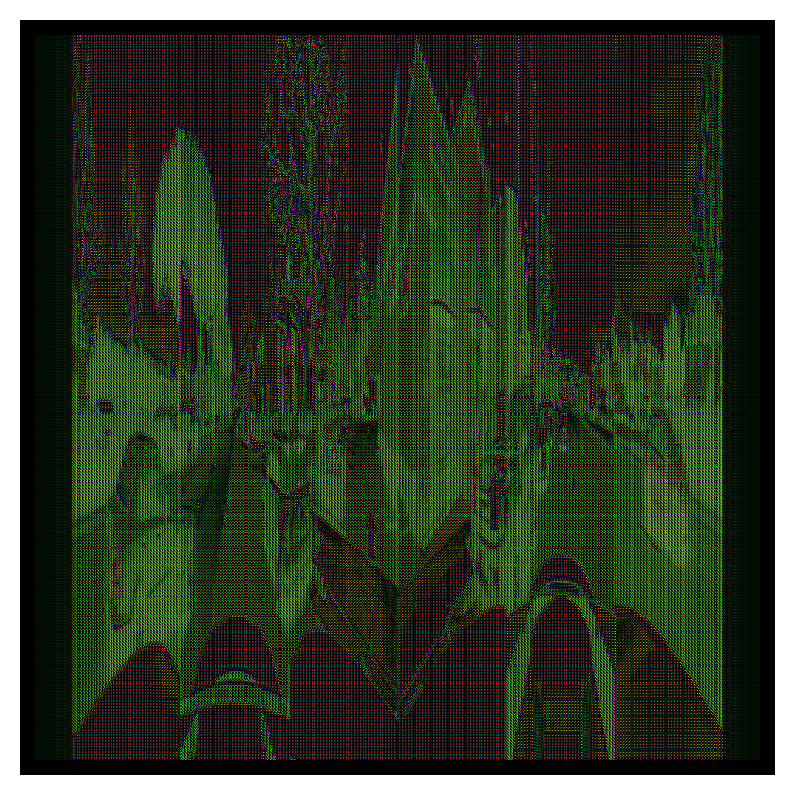

In [41]:
plot_image(m_test.return_image_tensor(images[0:1]).cpu().squeeze(0))

In [ ]:
%debug